# Fine-Tuned Named Entity Recognition 

Business Problem: Organizations processes a high volume of lab reports and EHRs daily, but manually extracting critical disease information from these unstructured documents is inefficient and prone to errors. This hampers timely clinical decision-making and workflow integration. An automated NER system for disease extraction would significantly enhance accuracy, speed, and overall operational efficiency.

Proposed Solution:
Fine-tune a ClinicalBERT-based NER model on a curated dataset to automatically extract disease entities from lab reports and EHRs. Enhance the process through hyperparameter tuning with Optuna, early stopping to prevent overfitting, and comprehensive experiment tracking with MLflow to ensure optimal performance and integration into existing workflows.

## Loading the data 

In [ ]:
import torch
import mlflow
from datasets import load_dataset
from transformers import AutoTokenizer
import torch
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, EarlyStoppingCallback
import matplotlib.pyplot as plt
import numpy as np
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
import optuna
from transformers import Trainer

In [2]:
#Checking for GPU availability becasue we will need it for this project  
mps_available = torch.backends.mps.is_available()
print("MPS Available:", mps_available)

MPS Available: True


In [3]:
# Starting an MLflow run to track our progress 
mlflow.start_run(run_name="NER_FineTuning_i2b2")
print("MLflow run started!")

MLflow run started!


In [4]:
# Load the NCBI Disease dataset
dataset = load_dataset("ncbi_disease")

# Inspect the dataset structure
print("Dataset splits:", dataset)
print("Sample from training split:", dataset["train"][0])


Dataset splits: DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 5433
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 924
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 941
    })
})
Sample from training split: {'id': '0', 'tokens': ['Identification', 'of', 'APC2', ',', 'a', 'homologue', 'of', 'the', 'adenomatous', 'polyposis', 'coli', 'tumour', 'suppressor', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0]}


# Data Preprocessing 

In [ ]:
# Load the ClinicalBERT tokenizer 
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_and_align_labels(examples):
    
    # Tokenize the tokens (each example's "tokens" field is a list of words)
    tokenized_inputs = tokenizer(
        examples["tokens"],
        padding="max_length",
        max_length=128,
        truncation=True,
        is_split_into_words=True
    )
    
    labels = []
    for i, ner_tags in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Special value to ignore in loss computation
            else:
                label_ids.append(ner_tags[word_idx])
        labels.append(label_ids)
    
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

# Apply the tokenization and label alignment to the dataset splits
tokenized_datasets = dataset.map(tokenize_and_align_labels, batched=True)
print("Tokenized dataset sample:")
print(tokenized_datasets["train"][0])

Tokenized dataset sample:
{'id': '0', 'tokens': ['Identification', 'of', 'APC2', ',', 'a', 'homologue', 'of', 'the', 'adenomatous', 'polyposis', 'coli', 'tumour', 'suppressor', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 0, 0], 'input_ids': [101, 9117, 1104, 170, 1643, 1665, 1477, 117, 170, 16358, 3702, 12733, 1104, 1103, 8050, 26601, 21943, 2285, 185, 23415, 5674, 4863, 1884, 2646, 189, 27226, 17203, 1766, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [6]:
# Logging the tokenizer in MLflow 
mlflow.log_param("tokenizer_model", model_name)
print("Logged tokenization parameters to MLflow.")

Logged tokenization parameters to MLflow.


In [7]:
# Check unique labels in the dataset
unique_labels = set(label for example in tokenized_datasets["train"]["labels"] for label in example)
print("Unique labels in dataset:", unique_labels)

# Check label mapping
label_mapping = dataset["train"].features["ner_tags"].feature
print(label_mapping)

Unique labels in dataset: {0, 1, 2, -100}
ClassLabel(names=['O', 'B-Disease', 'I-Disease'], id=None)


In [8]:
num_labels = len(dataset["train"].features["ner_tags"].feature.names)
print(f"Number of labels detected: {num_labels}")

Number of labels detected: 3


In [9]:
# Load the ClinicalBERT model with a token classification head
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)

# Set device to MPS (Apple GPU)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)
print(f"Model is set to device: {device}")


Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model is set to device: mps


# ML Modeling 

In [10]:
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=1,      # Stop training if no improvement after 1 evaluation
    early_stopping_threshold=0.0,# Minimum improvement needed to reset patience
)

An earlier version overfitted so let's use an early stop parameter 


In [11]:

# Define training arguments for a full-scale project
training_args = TrainingArguments(
    output_dir="./results_earlystop",
    eval_strategy="epoch", # Evaluate every epoch
    save_strategy= "epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,                    # Give room for early stopping
    weight_decay=0.01,
    logging_dir="./logs_earlystop",                  
    save_total_limit=1,
    # Required for EarlyStoppingCallback
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False , # Lower eval_loss = better
    report_to="none"
)

# Log training hyperparameters to MLflow
mlflow.log_param("num_labels", num_labels)
mlflow.log_param("num_train_epochs", training_args.num_train_epochs)
mlflow.log_param("batch_size", training_args.per_device_train_batch_size)
mlflow.log_param("weight_decay", training_args.weight_decay)

# Initialize the Trainer object using the validation set for evaluation
trainer_earlystop = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    callbacks=[early_stopping]
)

print("Model and Trainer are set up for full-scale fine-tuning")


Model and Trainer are set up for full-scale fine-tuning


In [12]:
# Fine-tune the model
print("Starting fine-tuning...")
train_output = trainer_earlystop.train()
print("Training complete.")

# Log training loss
mlflow.log_metric("train_loss", train_output.training_loss)
print(f"Training loss: {train_output.training_loss}")

# Evaluate the model on the validation set
print("Evaluating model on validation set...")
eval_metrics = trainer_earlystop.evaluate(eval_dataset=tokenized_datasets["validation"])
print("Validation evaluation metrics:")
print(eval_metrics)

# Log evaluation metrics to MLflow
for metric_name, metric_value in eval_metrics.items():
    mlflow.log_metric(metric_name, metric_value)

Starting fine-tuning...


  0%|          | 0/3400 [00:00<?, ?it/s]

{'loss': 0.1208, 'grad_norm': 2.2838492393493652, 'learning_rate': 4.2647058823529415e-05, 'epoch': 0.74}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.077816441655159, 'eval_runtime': 7.0102, 'eval_samples_per_second': 131.808, 'eval_steps_per_second': 16.547, 'epoch': 1.0}
{'loss': 0.0409, 'grad_norm': 1.9044270515441895, 'learning_rate': 3.529411764705883e-05, 'epoch': 1.47}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.06490051746368408, 'eval_runtime': 6.9073, 'eval_samples_per_second': 133.772, 'eval_steps_per_second': 16.794, 'epoch': 2.0}
{'loss': 0.0269, 'grad_norm': 0.07769875228404999, 'learning_rate': 2.7941176470588236e-05, 'epoch': 2.21}
{'loss': 0.0118, 'grad_norm': 0.16269870102405548, 'learning_rate': 2.058823529411765e-05, 'epoch': 2.94}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.08051025122404099, 'eval_runtime': 7.0577, 'eval_samples_per_second': 130.921, 'eval_steps_per_second': 16.436, 'epoch': 3.0}
{'train_runtime': 543.7271, 'train_samples_per_second': 49.961, 'train_steps_per_second': 6.253, 'train_loss': 0.049484982473008775, 'epoch': 3.0}
Training complete.
Training loss: 0.049484982473008775
Evaluating model on validation set...


  0%|          | 0/116 [00:00<?, ?it/s]

Validation evaluation metrics:
{'eval_loss': 0.06490051746368408, 'eval_runtime': 7.0156, 'eval_samples_per_second': 131.706, 'eval_steps_per_second': 16.535, 'epoch': 3.0}


In [13]:
trainer_earlystop.state.log_history  # Show loss over all epochs

[{'loss': 0.1208,
  'grad_norm': 2.2838492393493652,
  'learning_rate': 4.2647058823529415e-05,
  'epoch': 0.7352941176470589,
  'step': 500},
 {'eval_loss': 0.077816441655159,
  'eval_runtime': 7.0102,
  'eval_samples_per_second': 131.808,
  'eval_steps_per_second': 16.547,
  'epoch': 1.0,
  'step': 680},
 {'loss': 0.0409,
  'grad_norm': 1.9044270515441895,
  'learning_rate': 3.529411764705883e-05,
  'epoch': 1.4705882352941178,
  'step': 1000},
 {'eval_loss': 0.06490051746368408,
  'eval_runtime': 6.9073,
  'eval_samples_per_second': 133.772,
  'eval_steps_per_second': 16.794,
  'epoch': 2.0,
  'step': 1360},
 {'loss': 0.0269,
  'grad_norm': 0.07769875228404999,
  'learning_rate': 2.7941176470588236e-05,
  'epoch': 2.2058823529411766,
  'step': 1500},
 {'loss': 0.0118,
  'grad_norm': 0.16269870102405548,
  'learning_rate': 2.058823529411765e-05,
  'epoch': 2.9411764705882355,
  'step': 2000},
 {'eval_loss': 0.08051025122404099,
  'eval_runtime': 7.0577,
  'eval_samples_per_second': 1

# Evaluation

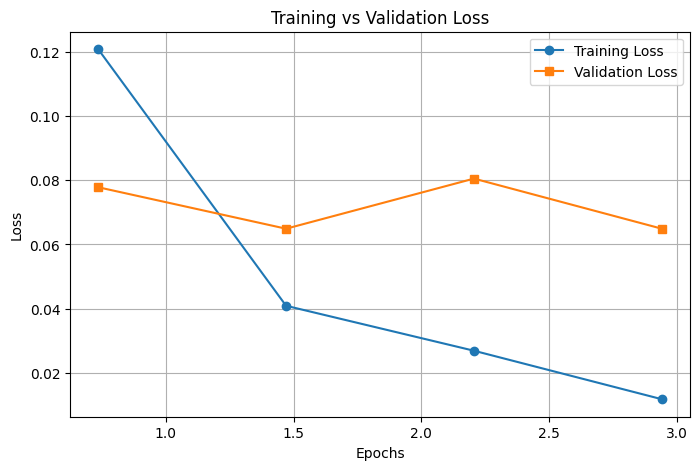

In [15]:
# Extract loss and epochs from trainer's log history
train_loss = []
eval_loss = []
epochs = []

for log in trainer_earlystop.state.log_history:
    if "loss" in log:  # Training loss
        train_loss.append(log["loss"])
        epochs.append(log["epoch"])
    if "eval_loss" in log:  # Validation loss
        eval_loss.append(log["eval_loss"])

# Plot the loss curves
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, label="Training Loss", marker="o")
plt.plot(epochs, eval_loss, label="Validation Loss", marker="s")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
final_metrics = trainer_earlystop.evaluate(eval_dataset=tokenized_datasets["test"])
print("Final test set evaluation:", final_metrics)

  0%|          | 0/118 [00:00<?, ?it/s]

Final test set evaluation: {'eval_loss': 0.08246713876724243, 'eval_runtime': 7.5237, 'eval_samples_per_second': 125.071, 'eval_steps_per_second': 15.684, 'epoch': 3.0}


## Tuning the hyperparameters (trail)



In [ ]:
label_list = tokenized_datasets["train"].features["ner_tags"].feature.names

def align_predictions(predictions, label_ids):
    """
    Aligns model predictions with true labels, ignoring subword pieces 
    that have label ID = -100.
    """
    preds = np.argmax(predictions, axis=2)
    
    batch_size, seq_len = preds.shape
    out_pred_list = []
    out_label_list = []
    
    for i in range(batch_size):
        pred_ids = preds[i]
        label_ids_i = label_ids[i]
        
        # Collect the actual labels/predictions for each valid token
        pred_label_list = []
        true_label_list = []
        for j in range(seq_len):
            # -100 is a special token label for subword pieces or padding
            if label_ids_i[j] == -100:
                continue
            pred_label_list.append(label_list[pred_ids[j]])
            true_label_list.append(label_list[label_ids_i[j]])
            
        out_pred_list.append(pred_label_list)
        out_label_list.append(true_label_list)
    
    return out_pred_list, out_label_list

def compute_metrics(eval_pred):
    """
    Called by the Trainer to compute precision, recall, and F1 using seqeval.
    """
    predictions, labels = eval_pred
    preds_list, refs_list = align_predictions(predictions, labels)
    
    precision = precision_score(refs_list, preds_list)
    recall = recall_score(refs_list, preds_list)
    f1 = f1_score(refs_list, preds_list)
    
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [21]:
predictions, labels, _ = trainer_earlystop.predict(tokenized_datasets["validation"])
preds_list, refs_list = align_predictions(predictions, labels)

report = classification_report(refs_list, preds_list)
print(report)


  0%|          | 0/116 [00:00<?, ?it/s]

              precision    recall  f1-score   support

     Disease       0.83      0.87      0.85      1679

   micro avg       0.83      0.87      0.85      1679
   macro avg       0.83      0.87      0.85      1679
weighted avg       0.83      0.87      0.85      1679



In [ ]:
def model_init():
    # This function is used to reinitialize your model for each trial.
    return AutoModelForTokenClassification.from_pretrained(model_name, num_labels=num_labels)

def hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16, 32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
    }

# Create a new Trainer instance for hyperparameter search
trainer = Trainer(
    model_init=model_init,
    args=training_args,  # You can set a base TrainingArguments here (consider reducing num_train_epochs)
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics 

# Run the hyperparameter search
best_run = trainer.hyperparameter_search(
    direction="minimize",   # if you're using eval_loss; change to "maximize" if using F1, for example
    hp_space=hp_space,
    backend="optuna",
    n_trials=10,            # Increase this number for a more thorough search
)

print("Best hyperparameters found:", best_run.hyperparameters)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-02-27 20:47:34,573] A new study created in memory with name: no-name-8f064abe-f3ad-47af-aeb4-d83ff916796b
Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1700 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.06615070253610611, 'eval_precision': 0.8172043010752689, 'eval_recall': 0.8147706968433591, 'eval_f1': 0.8159856844616762, 'eval_runtime': 7.7786, 'eval_samples_per_second': 118.787, 'eval_steps_per_second': 14.913, 'epoch': 1.0}
{'loss': 0.1016, 'grad_norm': 1.4521913528442383, 'learning_rate': 2.034860848600034e-05, 'epoch': 1.47}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.06498333066701889, 'eval_precision': 0.8316151202749141, 'eval_recall': 0.8648004764740918, 'eval_f1': 0.8478832116788323, 'eval_runtime': 7.7899, 'eval_samples_per_second': 118.615, 'eval_steps_per_second': 14.891, 'epoch': 2.0}
{'loss': 0.0215, 'grad_norm': 0.15320830047130585, 'learning_rate': 1.187002161683353e-05, 'epoch': 2.94}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.07892968505620956, 'eval_precision': 0.8516746411483254, 'eval_recall': 0.8481238832638476, 'eval_f1': 0.8498955535660997, 'eval_runtime': 290.7252, 'eval_samples_per_second': 3.178, 'eval_steps_per_second': 0.399, 'epoch': 3.0}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.09059405326843262, 'eval_precision': 0.8489250435793143, 'eval_recall': 0.8701608100059559, 'eval_f1': 0.8594117647058823, 'eval_runtime': 7.6741, 'eval_samples_per_second': 120.405, 'eval_steps_per_second': 15.116, 'epoch': 4.0}
{'loss': 0.006, 'grad_norm': 0.08838754892349243, 'learning_rate': 3.391434747666723e-06, 'epoch': 4.41}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.09739010781049728, 'eval_precision': 0.8486265341905318, 'eval_recall': 0.8648004764740918, 'eval_f1': 0.8566371681415929, 'eval_runtime': 7.7143, 'eval_samples_per_second': 119.778, 'eval_steps_per_second': 15.037, 'epoch': 5.0}


[I 2025-02-27 22:26:25,622] Trial 0 finished with value: 2.5700641788062164 and parameters: {'learning_rate': 2.8827195355167146e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.028725152477129354}. Best is trial 0 with value: 2.5700641788062164.


{'train_runtime': 5930.5362, 'train_samples_per_second': 4.581, 'train_steps_per_second': 0.287, 'train_loss': 0.038353532061857334, 'epoch': 5.0}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/850 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.07044104486703873, 'eval_precision': 0.7455716586151369, 'eval_recall': 0.8272781417510423, 'eval_f1': 0.7843026538678712, 'eval_runtime': 7.8414, 'eval_samples_per_second': 117.836, 'eval_steps_per_second': 14.793, 'epoch': 1.0}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.06319992989301682, 'eval_precision': 0.805365296803653, 'eval_recall': 0.840381179273377, 'eval_f1': 0.8225007286505392, 'eval_runtime': 7.6791, 'eval_samples_per_second': 120.327, 'eval_steps_per_second': 15.106, 'epoch': 2.0}
{'loss': 0.0792, 'grad_norm': 1.1682366132736206, 'learning_rate': 1.0616166208958189e-05, 'epoch': 2.94}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.07026535272598267, 'eval_precision': 0.8409225310467179, 'eval_recall': 0.8469326980345444, 'eval_f1': 0.8439169139465875, 'eval_runtime': 18.0894, 'eval_samples_per_second': 51.08, 'eval_steps_per_second': 6.413, 'epoch': 3.0}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.07913970202207565, 'eval_precision': 0.839766081871345, 'eval_recall': 0.8552709946396665, 'eval_f1': 0.8474476246680438, 'eval_runtime': 7.6334, 'eval_samples_per_second': 121.047, 'eval_steps_per_second': 15.196, 'epoch': 4.0}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.08275308459997177, 'eval_precision': 0.8221722003376477, 'eval_recall': 0.8701608100059559, 'eval_f1': 0.8454861111111112, 'eval_runtime': 7.6656, 'eval_samples_per_second': 120.538, 'eval_steps_per_second': 15.132, 'epoch': 5.0}


[I 2025-02-27 22:49:27,156] Trial 1 finished with value: 2.5378191214547146 and parameters: {'learning_rate': 2.5782117936041316e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.23511941931774577}. Best is trial 1 with value: 2.5378191214547146.


{'train_runtime': 1380.0471, 'train_samples_per_second': 19.684, 'train_steps_per_second': 0.616, 'train_loss': 0.0511501407623291, 'epoch': 5.0}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3400 [00:00<?, ?it/s]

{'loss': 0.1682, 'grad_norm': 0.5984926819801331, 'learning_rate': 1.0918186980861271e-05, 'epoch': 0.74}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.06730649620294571, 'eval_precision': 0.7850309510410804, 'eval_recall': 0.8308516974389517, 'eval_f1': 0.8072916666666666, 'eval_runtime': 9.677, 'eval_samples_per_second': 95.484, 'eval_steps_per_second': 11.987, 'epoch': 1.0}
{'loss': 0.0563, 'grad_norm': 3.0045418739318848, 'learning_rate': 9.035740949678294e-06, 'epoch': 1.47}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.0712394043803215, 'eval_precision': 0.8227272727272728, 'eval_recall': 0.8624181060154854, 'eval_f1': 0.8421052631578947, 'eval_runtime': 7.68, 'eval_samples_per_second': 120.312, 'eval_steps_per_second': 15.104, 'epoch': 2.0}
{'loss': 0.0378, 'grad_norm': 4.451746940612793, 'learning_rate': 7.153294918495315e-06, 'epoch': 2.21}
{'loss': 0.027, 'grad_norm': 4.572720527648926, 'learning_rate': 5.270848887312338e-06, 'epoch': 2.94}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.07438791543245316, 'eval_precision': 0.855688622754491, 'eval_recall': 0.8511018463371054, 'eval_f1': 0.8533890713645863, 'eval_runtime': 20.4852, 'eval_samples_per_second': 45.106, 'eval_steps_per_second': 5.663, 'epoch': 3.0}
{'loss': 0.0147, 'grad_norm': 0.00880899466574192, 'learning_rate': 3.38840285612936e-06, 'epoch': 3.68}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.08565828949213028, 'eval_precision': 0.8537015276145711, 'eval_recall': 0.8653960690887433, 'eval_f1': 0.8595090209997043, 'eval_runtime': 7.6857, 'eval_samples_per_second': 120.224, 'eval_steps_per_second': 15.093, 'epoch': 4.0}
{'loss': 0.012, 'grad_norm': 4.276855945587158, 'learning_rate': 1.5059568249463822e-06, 'epoch': 4.41}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.09095169603824615, 'eval_precision': 0.8458864426419467, 'eval_recall': 0.8695652173913043, 'eval_f1': 0.8575624082232012, 'eval_runtime': 7.7043, 'eval_samples_per_second': 119.934, 'eval_steps_per_second': 15.057, 'epoch': 5.0}


[I 2025-02-27 23:47:52,154] Trial 2 finished with value: 2.573014068256452 and parameters: {'learning_rate': 1.2800633012044249e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.17700541892077018}. Best is trial 1 with value: 2.5378191214547146.


{'train_runtime': 3503.859, 'train_samples_per_second': 7.753, 'train_steps_per_second': 0.97, 'train_loss': 0.04750889147029203, 'epoch': 5.0}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/850 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.07317893952131271, 'eval_precision': 0.732739420935412, 'eval_recall': 0.7837998808814771, 'eval_f1': 0.757410071942446, 'eval_runtime': 9.5661, 'eval_samples_per_second': 96.591, 'eval_steps_per_second': 12.126, 'epoch': 1.0}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.06472127139568329, 'eval_precision': 0.7844682048396173, 'eval_recall': 0.8302561048243002, 'eval_f1': 0.806712962962963, 'eval_runtime': 7.6975, 'eval_samples_per_second': 120.039, 'eval_steps_per_second': 15.07, 'epoch': 2.0}
{'loss': 0.0949, 'grad_norm': 1.7799471616744995, 'learning_rate': 7.249614868120951e-06, 'epoch': 2.94}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.0673893615603447, 'eval_precision': 0.8345111896348646, 'eval_recall': 0.8439547349612865, 'eval_f1': 0.8392063962096535, 'eval_runtime': 7.6897, 'eval_samples_per_second': 120.16, 'eval_steps_per_second': 15.085, 'epoch': 3.0}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.07437929511070251, 'eval_precision': 0.839811542991755, 'eval_recall': 0.8493150684931506, 'eval_f1': 0.8445365709209356, 'eval_runtime': 220.6718, 'eval_samples_per_second': 4.187, 'eval_steps_per_second': 0.526, 'epoch': 4.0}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.07536394894123077, 'eval_precision': 0.8227633069082673, 'eval_recall': 0.8653960690887433, 'eval_f1': 0.8435413642960813, 'eval_runtime': 245.052, 'eval_samples_per_second': 3.771, 'eval_steps_per_second': 0.473, 'epoch': 5.0}


[I 2025-02-28 00:32:45,212] Trial 3 finished with value: 2.531700740293092 and parameters: {'learning_rate': 1.760620753686517e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.19699215948964255}. Best is trial 3 with value: 2.531700740293092.


{'train_runtime': 2692.0346, 'train_samples_per_second': 10.091, 'train_steps_per_second': 0.316, 'train_loss': 0.06371749990126666, 'epoch': 5.0}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3400 [00:00<?, ?it/s]

{'loss': 0.1257, 'grad_norm': 0.30684584379196167, 'learning_rate': 3.0218860913647827e-05, 'epoch': 0.74}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.06951556354761124, 'eval_precision': 0.8008874098724348, 'eval_recall': 0.8600357355568791, 'eval_f1': 0.829408385985066, 'eval_runtime': 14.2247, 'eval_samples_per_second': 64.958, 'eval_steps_per_second': 8.155, 'epoch': 1.0}
{'loss': 0.0415, 'grad_norm': 1.956225037574768, 'learning_rate': 2.500871248026027e-05, 'epoch': 1.47}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.06643712520599365, 'eval_precision': 0.8358800226372383, 'eval_recall': 0.8796902918403812, 'eval_f1': 0.857225769007545, 'eval_runtime': 561.0465, 'eval_samples_per_second': 1.647, 'eval_steps_per_second': 0.207, 'epoch': 2.0}
{'loss': 0.026, 'grad_norm': 0.16093401610851288, 'learning_rate': 1.9798564046872715e-05, 'epoch': 2.21}
{'loss': 0.013, 'grad_norm': 0.040554825216531754, 'learning_rate': 1.4588415613485157e-05, 'epoch': 2.94}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.08327718824148178, 'eval_precision': 0.8430094786729858, 'eval_recall': 0.847528290649196, 'eval_f1': 0.8452628452628452, 'eval_runtime': 7.6858, 'eval_samples_per_second': 120.221, 'eval_steps_per_second': 15.093, 'epoch': 3.0}
{'loss': 0.0061, 'grad_norm': 0.0014870051527395844, 'learning_rate': 9.378267180097602e-06, 'epoch': 3.68}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.09810280054807663, 'eval_precision': 0.8456260720411664, 'eval_recall': 0.8808814770696843, 'eval_f1': 0.8628938156359393, 'eval_runtime': 7.8213, 'eval_samples_per_second': 118.139, 'eval_steps_per_second': 14.831, 'epoch': 4.0}
{'loss': 0.0035, 'grad_norm': 6.654818058013916, 'learning_rate': 4.168118746710045e-06, 'epoch': 4.41}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.10851959884166718, 'eval_precision': 0.8478760045924225, 'eval_recall': 0.8796902918403812, 'eval_f1': 0.8634902075416545, 'eval_runtime': 7.8011, 'eval_samples_per_second': 118.444, 'eval_steps_per_second': 14.87, 'epoch': 5.0}


[I 2025-02-28 01:40:53,974] Trial 4 finished with value: 2.591056503974458 and parameters: {'learning_rate': 3.542900934703538e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.030145947653600434}. Best is trial 3 with value: 2.531700740293092.


{'train_runtime': 4087.9057, 'train_samples_per_second': 6.645, 'train_steps_per_second': 0.832, 'train_loss': 0.03200999477330376, 'epoch': 5.0}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/3400 [00:00<?, ?it/s]

{'loss': 0.1605, 'grad_norm': 0.528659999370575, 'learning_rate': 1.2566656133341649e-05, 'epoch': 0.74}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.06672558933496475, 'eval_precision': 0.7920403587443946, 'eval_recall': 0.8415723645026801, 'eval_f1': 0.8160554432572913, 'eval_runtime': 7.7482, 'eval_samples_per_second': 119.253, 'eval_steps_per_second': 14.971, 'epoch': 1.0}
{'loss': 0.053, 'grad_norm': 2.845906972885132, 'learning_rate': 1.0399991282765503e-05, 'epoch': 1.47}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.07107449322938919, 'eval_precision': 0.8273299028016009, 'eval_recall': 0.8618225134008338, 'eval_f1': 0.8442240373395566, 'eval_runtime': 7.7784, 'eval_samples_per_second': 118.791, 'eval_steps_per_second': 14.913, 'epoch': 2.0}
{'loss': 0.0348, 'grad_norm': 3.540623903274536, 'learning_rate': 8.233326432189357e-06, 'epoch': 2.21}
{'loss': 0.0231, 'grad_norm': 2.048799753189087, 'learning_rate': 6.066661581613209e-06, 'epoch': 2.94}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.07626258581876755, 'eval_precision': 0.8633615477629988, 'eval_recall': 0.8505062537224538, 'eval_f1': 0.8568856885688568, 'eval_runtime': 7.725, 'eval_samples_per_second': 119.612, 'eval_steps_per_second': 15.016, 'epoch': 3.0}
{'loss': 0.0122, 'grad_norm': 0.008447899483144283, 'learning_rate': 3.899996731037064e-06, 'epoch': 3.68}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.08925382047891617, 'eval_precision': 0.8547912992357437, 'eval_recall': 0.8659916617033949, 'eval_f1': 0.8603550295857988, 'eval_runtime': 7.7218, 'eval_samples_per_second': 119.661, 'eval_steps_per_second': 15.022, 'epoch': 4.0}
{'loss': 0.0095, 'grad_norm': 6.074059963226318, 'learning_rate': 1.733331880460917e-06, 'epoch': 4.41}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.09409289062023163, 'eval_precision': 0.8514219384793964, 'eval_recall': 0.8737343656938654, 'eval_f1': 0.8624338624338624, 'eval_runtime': 7.7715, 'eval_samples_per_second': 118.895, 'eval_steps_per_second': 14.926, 'epoch': 5.0}


[I 2025-02-28 01:56:07,544] Trial 5 finished with value: 2.587590166607124 and parameters: {'learning_rate': 1.4733320983917795e-05, 'per_device_train_batch_size': 8, 'weight_decay': 0.05853815884441146}. Best is trial 3 with value: 2.531700740293092.


{'train_runtime': 912.2753, 'train_samples_per_second': 29.777, 'train_steps_per_second': 3.727, 'train_loss': 0.043887468716677494, 'epoch': 5.0}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1700 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

[I 2025-02-28 01:58:35,038] Trial 6 pruned. 


{'eval_loss': 0.06594984978437424, 'eval_precision': 0.8152109328579917, 'eval_recall': 0.8171530673019655, 'eval_f1': 0.8161808447352766, 'eval_runtime': 7.7641, 'eval_samples_per_second': 119.01, 'eval_steps_per_second': 14.941, 'epoch': 1.0}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1700 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.0688372328877449, 'eval_precision': 0.7840512223515715, 'eval_recall': 0.802263251935676, 'eval_f1': 0.7930526935531351, 'eval_runtime': 7.7699, 'eval_samples_per_second': 118.92, 'eval_steps_per_second': 14.929, 'epoch': 1.0}
{'loss': 0.1286, 'grad_norm': 2.194828510284424, 'learning_rate': 1.053784296430219e-05, 'epoch': 1.47}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.06655013561248779, 'eval_precision': 0.8141950375072129, 'eval_recall': 0.840381179273377, 'eval_f1': 0.8270808909730363, 'eval_runtime': 7.7162, 'eval_samples_per_second': 119.748, 'eval_steps_per_second': 15.033, 'epoch': 2.0}
{'loss': 0.0348, 'grad_norm': 1.0143510103225708, 'learning_rate': 6.14707506250961e-06, 'epoch': 2.94}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.0716480240225792, 'eval_precision': 0.8467933491686461, 'eval_recall': 0.8493150684931506, 'eval_f1': 0.848052334225394, 'eval_runtime': 7.7491, 'eval_samples_per_second': 119.24, 'eval_steps_per_second': 14.969, 'epoch': 3.0}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.07937688380479813, 'eval_precision': 0.8401162790697675, 'eval_recall': 0.8606313281715307, 'eval_f1': 0.8502500735510444, 'eval_runtime': 7.7391, 'eval_samples_per_second': 119.393, 'eval_steps_per_second': 14.989, 'epoch': 4.0}
{'loss': 0.0153, 'grad_norm': 0.6470628380775452, 'learning_rate': 1.7563071607170316e-06, 'epoch': 4.41}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.08212998509407043, 'eval_precision': 0.8371014492753623, 'eval_recall': 0.8600357355568791, 'eval_f1': 0.8484136310223267, 'eval_runtime': 7.8087, 'eval_samples_per_second': 118.33, 'eval_steps_per_second': 14.855, 'epoch': 5.0}


[I 2025-02-28 02:10:59,595] Trial 7 finished with value: 2.5455508158545683 and parameters: {'learning_rate': 1.4928610866094769e-05, 'per_device_train_batch_size': 16, 'weight_decay': 0.09383827871268667}. Best is trial 3 with value: 2.531700740293092.


{'train_runtime': 743.8592, 'train_samples_per_second': 36.519, 'train_steps_per_second': 2.285, 'train_loss': 0.053803778816671935, 'epoch': 5.0}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/850 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

[I 2025-02-28 02:13:15,864] Trial 8 pruned. 


{'eval_loss': 0.06617947667837143, 'eval_precision': 0.7777173913043478, 'eval_recall': 0.8522930315664086, 'eval_f1': 0.8132992327365729, 'eval_runtime': 7.7767, 'eval_samples_per_second': 118.817, 'eval_steps_per_second': 14.916, 'epoch': 1.0}


Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/1700 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

[I 2025-02-28 02:15:41,215] Trial 9 pruned. 


{'eval_loss': 0.06508862972259521, 'eval_precision': 0.8417874396135265, 'eval_recall': 0.8302561048243002, 'eval_f1': 0.8359820089955022, 'eval_runtime': 7.6586, 'eval_samples_per_second': 120.649, 'eval_steps_per_second': 15.146, 'epoch': 1.0}
Best hyperparameters found: {'learning_rate': 1.760620753686517e-05, 'per_device_train_batch_size': 32, 'weight_decay': 0.19699215948964255}


In [26]:
mlflow.end_run()

In [27]:
# Start an MLflow run for final training
mlflow.start_run(run_name="NER_Final_Training")

# Extract best hyperparameters from your hyperparameter search (best_run is assumed to be available)
best_hparams = best_run.hyperparameters

# Create new TrainingArguments with the best hyperparameters
final_training_args = TrainingArguments(
    output_dir="./final_results",
    num_train_epochs=5,  # Final training for 5 epochs
    per_device_train_batch_size=best_hparams["per_device_train_batch_size"],
    learning_rate=best_hparams["learning_rate"],
    weight_decay=best_hparams["weight_decay"],
    evaluation_strategy="epoch",
    logging_dir="./final_logs",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",  # Using eval_loss; change if you prefer F1, etc.
    greater_is_better=False,           # Set to False because lower eval_loss is better
    report_to="none"                   # Change this if you want to log to other systems
)

# Log the best hyperparameters to MLflow
for param, value in best_hparams.items():
    mlflow.log_param(f"final_{param}", value)
mlflow.log_param("final_num_train_epochs", final_training_args.num_train_epochs)

# Reinitialize the model with your ClinicalBERT model and the correct number of labels
final_model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=num_labels)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
final_model.to(device)

# Create the final Trainer with early stopping and MLflow logging integrated
final_trainer = Trainer(
    model=final_model,
    args=final_training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.0)]
)

# Start final training
final_train_output = final_trainer.train()
print("Final training complete.")
print("Final training loss:", final_train_output.training_loss)
mlflow.log_metric("final_train_loss", final_train_output.training_loss)

# Evaluate on the validation set
final_eval_metrics = final_trainer.evaluate()
print("Final evaluation metrics:", final_eval_metrics)
for metric_name, metric_value in final_eval_metrics.items():
    mlflow.log_metric(f"final_{metric_name}", metric_value)

# Generate a detailed classification report on the validation set
predictions, labels, _ = final_trainer.predict(tokenized_datasets["validation"])
preds_list, refs_list = align_predictions(predictions, labels)
from seqeval.metrics import classification_report
report = classification_report(refs_list, preds_list)
print("Detailed Classification Report:\n", report)
mlflow.log_text(report, "final_classification_report.txt")

# End the MLflow run
mlflow.end_run()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/850 [00:00<?, ?it/s]

  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.07375098019838333, 'eval_precision': 0.7448313384113167, 'eval_recall': 0.8153662894580107, 'eval_f1': 0.7785044071651976, 'eval_runtime': 7.8166, 'eval_samples_per_second': 118.21, 'eval_steps_per_second': 14.84, 'epoch': 1.0}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.0658111423254013, 'eval_precision': 0.7988338192419825, 'eval_recall': 0.8159618820726623, 'eval_f1': 0.807307012374779, 'eval_runtime': 7.6843, 'eval_samples_per_second': 120.246, 'eval_steps_per_second': 15.096, 'epoch': 2.0}
{'loss': 0.0931, 'grad_norm': 1.306370496749878, 'learning_rate': 7.249614868120951e-06, 'epoch': 2.94}


  0%|          | 0/116 [00:00<?, ?it/s]

{'eval_loss': 0.06892029196023941, 'eval_precision': 0.8230547550432277, 'eval_recall': 0.8505062537224538, 'eval_f1': 0.8365553602811951, 'eval_runtime': 7.7152, 'eval_samples_per_second': 119.763, 'eval_steps_per_second': 15.035, 'epoch': 3.0}
{'train_runtime': 491.0387, 'train_samples_per_second': 55.322, 'train_steps_per_second': 1.731, 'train_loss': 0.09197507985666686, 'epoch': 3.0}
Final training complete.
Final training loss: 0.09197507985666686


  0%|          | 0/116 [00:00<?, ?it/s]

Final evaluation metrics: {'eval_loss': 0.0658111423254013, 'eval_precision': 0.7988338192419825, 'eval_recall': 0.8159618820726623, 'eval_f1': 0.807307012374779, 'eval_runtime': 7.8619, 'eval_samples_per_second': 117.529, 'eval_steps_per_second': 14.755, 'epoch': 3.0}


  0%|          | 0/116 [00:00<?, ?it/s]

Detailed Classification Report:
               precision    recall  f1-score   support

     Disease       0.80      0.82      0.81      1679

   micro avg       0.80      0.82      0.81      1679
   macro avg       0.80      0.82      0.81      1679
weighted avg       0.80      0.82      0.81      1679



Looks like the search space for the hyperparameters needed to be wider to find the most optimal fit, but due to compute restraints we'll keep the original model with early stoppage as the best model for this project 